Training Complete!


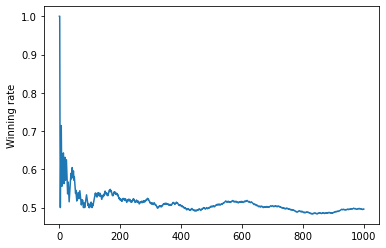

In [18]:
import numpy as np
from math import inf as infinity
import itertools
import random
import time
import matplotlib.pyplot as plt
    
def check_current_state(board_state):    # check whether one agent win or not
    # Check horizontals
    if (board_state[0][0] == board_state[0][1] and board_state[0][1] == board_state[0][2] and board_state[0][0] != ' '):
        return board_state[0][0], "Done"
    if (board_state[1][0] == board_state[1][1] and board_state[1][1] == board_state[1][2] and board_state[1][0] != ' '):
        return board_state[1][0], "Done"
    if (board_state[2][0] == board_state[2][1] and board_state[2][1] == board_state[2][2] and board_state[2][0] != ' '):
        return board_state[2][0], "Done"
    
    # Check verticals
    if (board_state[0][0] == board_state[1][0] and board_state[1][0] == board_state[2][0] and board_state[0][0] != ' '):
        return board_state[0][0], "Done"
    if (board_state[0][1] == board_state[1][1] and board_state[1][1] == board_state[2][1] and board_state[0][1] != ' '):
        return board_state[0][1], "Done"
    if (board_state[0][2] == board_state[1][2] and board_state[1][2] == board_state[2][2] and board_state[0][2] != ' '):
        return board_state[0][2], "Done"
    
    # Check diagonals
    if (board_state[0][0] == board_state[1][1] and board_state[1][1] == board_state[2][2] and board_state[0][0] != ' '):
        return board_state[1][1], "Done"
    if (board_state[2][0] == board_state[1][1] and board_state[1][1] == board_state[0][2] and board_state[2][0] != ' '):
        return board_state[1][1], "Done"
    # Check if draw
    draw = 0
    for i in range(3):
        for j in range(3):
            if board_state[i][j] == ' ':
                draw = 1
    if draw == 0:
        return None, "Draw"
    
    return None, "Not Done"
    

def play_move(state, player, block_num):  
    if state[int((block_num-1)/3)][(block_num-1)%3] == ' ':
        state[int((block_num-1)/3)][(block_num-1)%3] = player
    else:
        block_num = int(input("occupied "))
        play_move(state, player, block_num)
    
def copy_board_state(state): # copy current board state
    new_state = [[' ',' ',' '],[' ',' ',' '],[' ',' ',' ']]
    for i in range(3):
        for j in range(3):
            new_state[i][j] = state[i][j]
    return new_state

# Initialize state values
player = ['A','B',' ']
states_dict = {}
all_possible_states = [[list(i[0:3]),list(i[3:6]),list(i[6:9])] for i in itertools.product(player, repeat = 9)]
n_states = len(all_possible_states) # 2 players, 9 spaces
n_actions = 9   # 9 spaces
state_values_for_AI_B = np.full((n_states),0.0)
state_values_for_AI_A = np.full((n_states),0.0)

for i in range(n_states):
    states_dict[i] = all_possible_states[i]
    winner, _ = check_current_state(states_dict[i])
    if winner == 'B':   # AI won
        state_values_for_AI_B[i] = 1
    elif winner == 'A':   # AI lost
        state_values_for_AI_B[i] = -1
        
for i in range(n_states):
    winner, _ = check_current_state(states_dict[i])
    if winner == 'B':   # AI lost
        state_values_for_AI_A[i] = -1
    elif winner == 'A':   # AI won
        state_values_for_AI_A[i] = 1

def update_state_value_B(curr_state_idx, next_state_idx, learning_rate):   # Target function Linear combination of board state
    new_value = state_values_for_AI_B[curr_state_idx] + learning_rate*(state_values_for_AI_B[next_state_idx]  - state_values_for_AI_B[curr_state_idx])
    state_values_for_AI_B[curr_state_idx] = new_value
    
def update_state_value_A(curr_state_idx, next_state_idx, learning_rate):
    new_value = state_values_for_AI_A[curr_state_idx] + learning_rate*(state_values_for_AI_A[next_state_idx]  - state_values_for_AI_A[curr_state_idx])
    state_values_for_AI_A[curr_state_idx] = new_value

def getBestMove(state, player, epsilon):
    '''
    Reinforcement Learning Algorithm
    '''    
    moves = []
    curr_state_values = []
    empty_cells = []
    for i in range(3):
        for j in range(3):
            if state[i][j] == ' ':
                empty_cells.append(i*3 + (j+1))
    
    for empty_cell in empty_cells:
        moves.append(empty_cell)
        new_state = copy_board_state(state)
        play_move(new_state, player, empty_cell)
        next_state_idx = list(states_dict.keys())[list(states_dict.values()).index(new_state)]
        if player == 'A':
            curr_state_values.append(state_values_for_AI_A[next_state_idx])
        else:
            curr_state_values.append(state_values_for_AI_B[next_state_idx])

    best_move_idx = np.argmax(curr_state_values)
    
    if np.random.uniform(0,1) <= epsilon:       # Exploration
        best_move = random.choice(empty_cells)

        epsilon *= 0.99
    else:   #Exploitation
        best_move = moves[best_move_idx]

    return best_move


#LOAD TRAINED STATE VALUES
state_values_for_AI_A = np.loadtxt('trained_state_values_A.txt', dtype=np.float64)
state_values_for_AI_B = np.loadtxt('trained_state_values_B.txt', dtype=np.float64)

learning_rate = 0.2
epsilon = 0.2
num_iterations = 1000
x = np.arange(num_iterations)+1
y = np.zeros(num_iterations)
winning_times = 0
for iteration in range(num_iterations):
    board_state = [[' ',' ',' '],
              [' ',' ',' '],
              [' ',' ',' ']]
    current_state = "Not Done"

    winner = None
    current_player_idx = random.choice([0,1])
        
    while current_state == "Not Done":
        curr_state_idx = list(states_dict.keys())[list(states_dict.values()).index(board_state)]
        if current_player_idx == 0:     
            block_choice = getBestMove(board_state, players[current_player_idx], epsilon)
            play_move(board_state ,players[current_player_idx], block_choice)
            new_state_idx = list(states_dict.keys())[list(states_dict.values()).index(board_state)]
            
        else:       
            block_choice = getBestMove(board_state, players[current_player_idx], epsilon)
            play_move(board_state ,players[current_player_idx], block_choice)
            new_state_idx = list(states_dict.keys())[list(states_dict.values()).index(board_state)]

        update_state_value_B(curr_state_idx, new_state_idx, learning_rate)
        update_state_value_A(curr_state_idx, new_state_idx, learning_rate)
        winner, current_state = check_current_state(board_state)
        if winner == 'A':
            winning_times = winning_times + 1
            y[iteration] = winning_times/(iteration+1)
        else:
            y[iteration] = winning_times/(iteration+1)

print('Training Complete!')    

# Save state values for future use
np.savetxt('trained_state_values_A.txt', state_values_for_AI_A, fmt = '%.6f')
np.savetxt('trained_state_values_B.txt', state_values_for_AI_B, fmt = '%.6f')
    

plt.plot(x,y)
plt.ylabel('Winning rate')
plt.show()